### Install libraries 

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install statsmodels

### Set up variables for MLFlow

In [176]:
import os

# Set the MLflow tracking URI and credentials as environment variables
os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/Francesco-Ranieri/price-oracle.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = ""
os.environ["MLFLOW_TRACKING_PASSWORD"] = ""

### Load Data

In [94]:
import pandas as pd
import os

folder = os.path.join("..", "airflow", "assets")
dfs = []
for file in os.listdir(folder):
    if file.endswith(".csv"):
        dfs.append(pd.read_csv(os.path.join(folder, file), skiprows=1, parse_dates=['date']))
print(dfs.__len__())

24


In [95]:
# For the first dataframe, print summary, info, and head
print(dfs[0].describe())
print(dfs[0].info())
print(dfs[0].head())

               unix                           date         open         high  \
count  7.595000e+03                           7595  7595.000000  7595.000000   
mean   1.645029e+09  2022-02-16 16:37:50.915075584    29.022282    29.255667   
min    1.628780e+09            2021-08-12 15:00:00     2.900000     2.900000   
25%    1.635709e+09            2021-10-31 19:30:00    15.715000    15.787100   
50%    1.643256e+09            2022-01-27 04:00:00    22.441000    22.616900   
75%    1.650829e+09            2022-04-24 19:30:00    44.632600    44.836300   
max    1.696108e+09            2023-09-30 21:00:00   346.500000   499.000000   
std    1.192431e+07                            NaN    19.383015    20.225280   

               low        close    Volume ICP     Volume USD  
count  7595.000000  7595.000000   7595.000000    7595.000000  
mean     28.800396    28.991883    193.303991    7999.042266  
min       2.800000     2.887000      0.009011       0.034204  
25%      15.654550    15.70

### Merge all data into one dataframe

In [143]:
import pandas as pd

# Step 1: Convert "date" column to datetime in all dataframes
for df in dfs:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

# Step 2: Find the oldest and newest dates across all dataframes
all_dates = [df['date'] for df in dfs]
all_dates_flat = [date for sublist in all_dates for date in sublist if not pd.isnull(date)]

oldest_date = min(all_dates_flat)
newest_date = max(all_dates_flat)

# Step 3: Create a new dataframe with the date range
date_range = pd.date_range(start=oldest_date, end=newest_date, freq='H')  # Hourly frequency
merged_df = pd.DataFrame({'date': date_range})

# Step 4: Add "close" columns from each dataframe to the merged_df using list comprehension
for df in dfs:
    try:
        ticker = df['symbol'].iloc[0]  # Assuming each dataframe has a "ticker" column
        close_col_name = f'close_{ticker}'
        
        df = df.set_index('date').sort_index()
        df = df[~df.index.duplicated(keep='first')].reindex(date_range, method='ffill')
        
        # Create a DataFrame with the "date" and "close" columns
        close_data = df[df.index.isin(date_range)][['close']]
        close_data.rename(columns={'close': close_col_name}, inplace=True)
        
        # Merge the "close_data" into the "merged_df"
        merged_df = pd.merge(merged_df, close_data, left_on='date', right_index=True, how='left')
    except ValueError as e:
        print(f'Error on coin {ticker}: {e}')
        

# Now, merged_df contains the desired data with the date range and "close_{ticker}" columns, with missing hours filled.


Error on coin CAKE/USD: index must be monotonic increasing or decreasing
Error on coin SHIB/USD: index must be monotonic increasing or decreasing
Error on coin AAVE/USD: index must be monotonic increasing or decreasing
Error on coin DASH/USD: index must be monotonic increasing or decreasing
Error on coin DOT/USD: index must be monotonic increasing or decreasing
Error on coin SNX/USD: index must be monotonic increasing or decreasing
Error on coin CRO/USD: index must be monotonic increasing or decreasing


### Plot the timeseries and the scaled timeseries

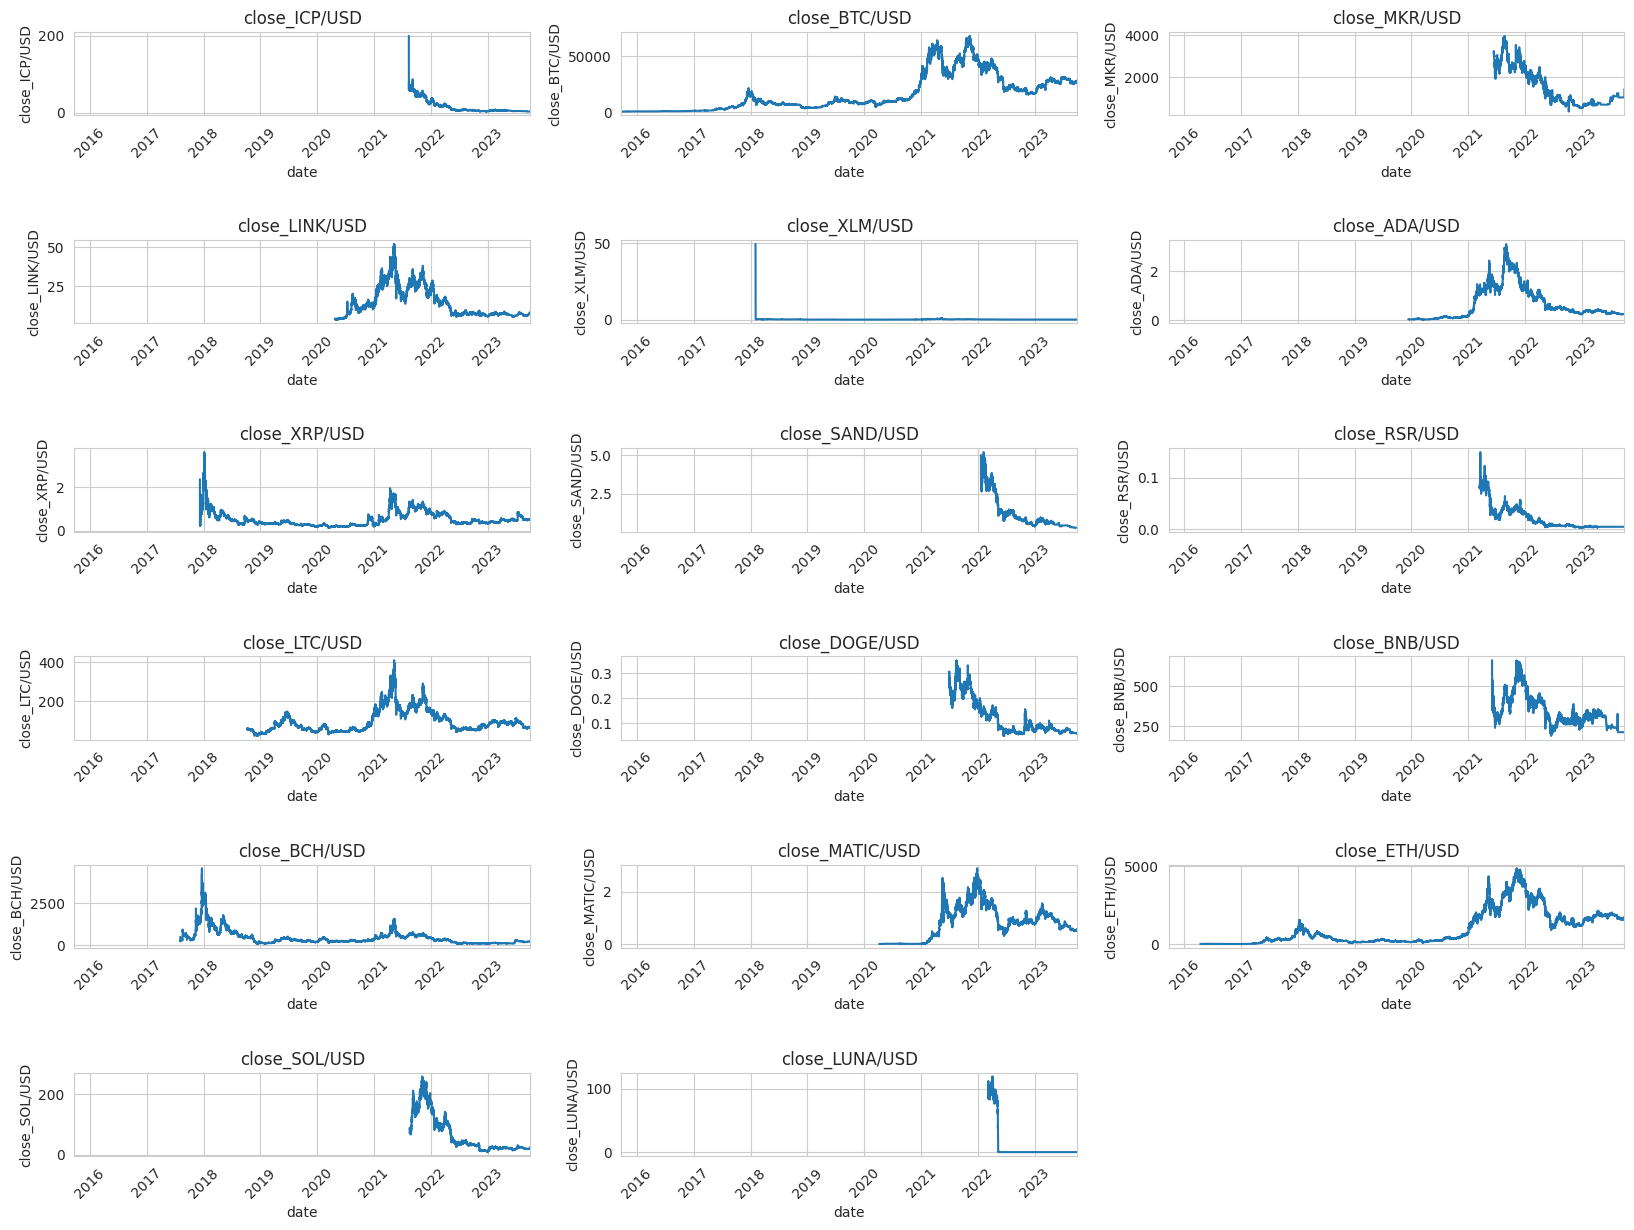

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots with vertical space using Seaborn
plt.figure(figsize=(20, 20))
grid = plt.GridSpec(8, 3, hspace=1.5)  # Adjust the value of hspace as needed

for i, col in enumerate(merged_df.columns[1:]):
    ax = plt.subplot(grid[i // 3, i % 3])
    sns.lineplot(data=merged_df, x="date", y=col, ax=ax)
    ax.set_title(col)
    
    # Rotate x-axis labels to an oblique angle
    plt.xticks(rotation=45)  # You can adjust the angle as needed
    
    # Set x-axis limits to display the full date range
    ax.set_xlim(merged_df['date'].min(), merged_df['date'].max())

plt.show()

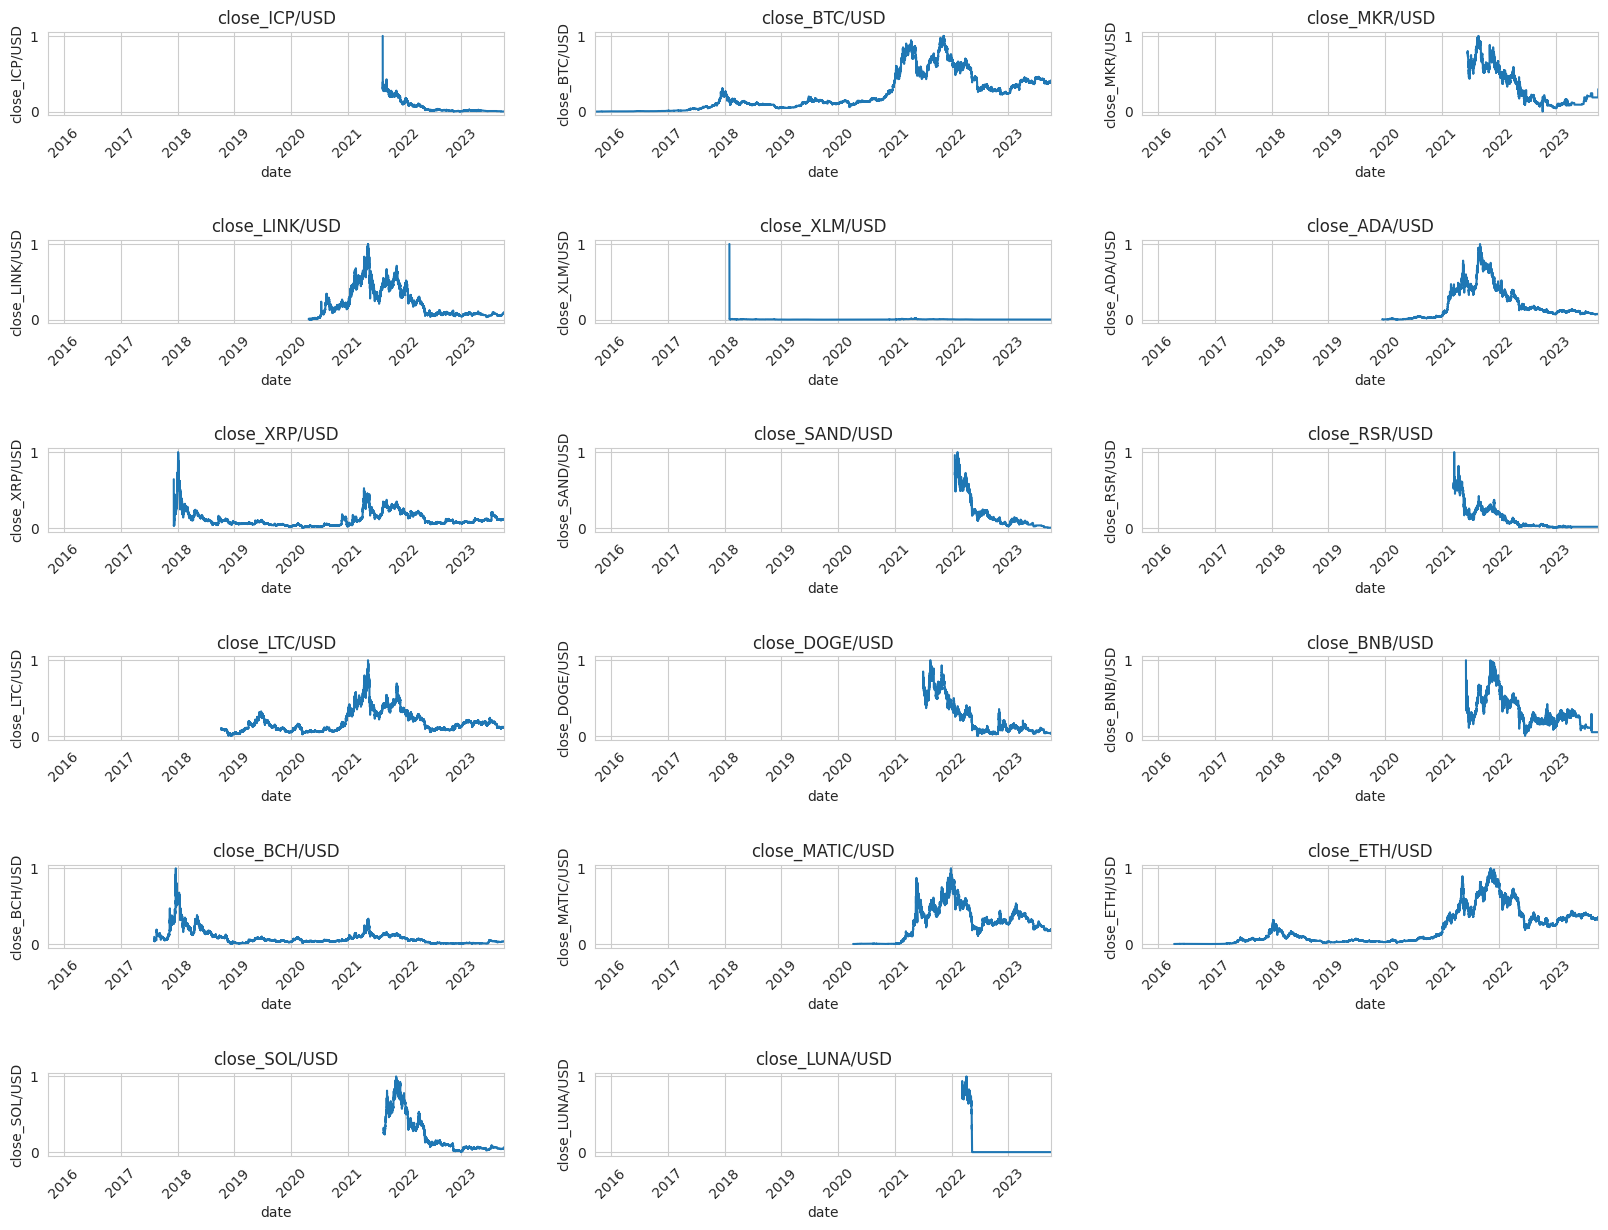

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a custom Min-Max scaling function
def custom_min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column

# Scale the numeric columns in the DataFrame (excluding 'date')
numeric_cols = merged_df.columns[1:]
scaled_df = merged_df.copy()
scaled_df[numeric_cols] = scaled_df[numeric_cols].apply(custom_min_max_scaling, axis=0)

# Create subplots with vertical space using Seaborn
plt.figure(figsize=(20, 20))
grid = plt.GridSpec(8, 3, hspace=1.5)  # Adjust the value of hspace as needed

for i, col in enumerate(scaled_df.columns[1:]):
    ax = plt.subplot(grid[i // 3, i % 3])
    sns.lineplot(data=scaled_df, x="date", y=col, ax=ax)
    ax.set_title(col)
    
    # Rotate x-axis labels to an oblique angle
    plt.xticks(rotation=45)  # You can adjust the angle as needed

    # Set x-axis limits to display the full date range
    ax.set_xlim(merged_df['date'].min(), merged_df['date'].max())


# Display the plots
plt.show()


### Clustering Analysis

### Clustering Analysis (on Raw Series)

In [ ]:
!pip install fastdtw
!pip install mlflow

In [206]:
%%bash --bg
mlflow server

In [239]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from fastdtw import fastdtw
from tqdm import tqdm
import mlflow
import mlflow.sklearn
from sklearn.metrics import silhouette_score

# os.environ["MLFLOW_TRACKING_URI"] = "http://localhost:5000"
os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/Francesco-Ranieri/price-oracle.mlflow"

# Create MLflow experiment
mlflow.set_experiment("KMeans_Clustering")

# Assuming you have a DataFrame named 'merged_df' with time series columns

# Select the time series columns for clustering
time_series_data = merged_df.iloc[:, 1:].values  # Exclude the 'date' column

# Backfill missing values
time_series_data = pd.DataFrame(time_series_data).fillna(method='bfill').values

# Transpose the data to have time series in rows and measurements in columns
time_series_data = time_series_data.T

# Number of clusters to try
cluster_range = range(2, 8)

# Initialize an empty array to store the distances
distances = np.zeros((time_series_data.shape[0], time_series_data.shape[0]))
# Calculate DTW distances between time series columns with progress tracking
for i in tqdm(range(time_series_data.shape[0]), desc="Calculating DTW Distances"):
    for j in range(i, time_series_data.shape[0]):
        distance, _ = fastdtw(time_series_data[i], time_series_data[j])
        distances[i, j] = distance
        distances[j, i] = distance

print("DTW distances calculated.")

# Silhouette Score vs. Cluster Count
silhouette_scores = []
inertia_scores = []

# Iterate through different cluster counts
for n_clusters in cluster_range:
    # Create a unique experiment name for each cluster count
    run_name = f"KMeans_Clustering_{n_clusters}_Clusters"
    
    with mlflow.start_run(run_name=run_name):
        print(f"Running experiment for {n_clusters} clusters...")
                
        # Perform K-Means clustering with DTW distances
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(distances)
        
        # Get cluster labels
        labels = kmeans.labels_
        
        print("K-Means clustering completed.")
        
        # Log clustering results and distances to MLflow
        mlflow.log_param("Cluster_Count", n_clusters)
        mlflow.log_param("Distance_Matrix_Shape", distances.shape)
        mlflow.log_param("Cluster_Labels", labels.tolist())
        
        print("Clustering results logged to MLflow.")
        
        # Calculate Silhouette Score and Inertia
        silhouette = silhouette_score(distances, labels, metric="precomputed")
        inertia_score = kmeans.inertia_
        
        silhouette_scores.append(silhouette)
        inertia_scores.append(inertia_score)
        
        mlflow.log_param("Silhouette_Score", silhouette)
        mlflow.log_param("Inertia_Score", inertia_score)
        
        print(f"Silhouette Score: {silhouette}")
        print(f"Inertia Score: {inertia_score}")
        
        # Define a color palette for plotting
        palette = sns.color_palette("husl", n_clusters)
        
        # Visualize the clustered time series using Seaborn
        num_rows = n_clusters
        num_cols = 1
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
        
        for cluster_id in range(n_clusters):
            ax = axes[cluster_id] if num_rows > 1 else axes
            for series_idx, label in enumerate(labels):
                if label == cluster_id:
                    series_name = merged_df.columns[series_idx + 1]  # Get the column name (series name)
                    sns.lineplot(data=time_series_data[series_idx], color=palette[cluster_id], label=series_name, ax=ax)
            
            ax.annotate(f"Inertia: {inertia_score:.2f}", xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
            ax.annotate(f"Silhouette: {silhouette:.2f}", xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)
            
            ax.set_title(f"Cluster {cluster_id + 1}")
            ax.legend(loc='upper right')  # Add legends for series in the cluster
        
        plt.tight_layout()
        
        # Save the plot to a file and log it to MLflow
        plot_path = f"cluster_plots_{n_clusters}_clusters.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        
        print("Cluster visualization plot saved and logged to MLflow.")
        
        plt.show()

# Log the lists of Silhouette and Inertia scores
mlflow.log_param("Silhouette_Scores", silhouette_scores)
mlflow.log_param("Inertia_Scores", inertia_scores)

# Silhouette Score vs. Cluster Count plot
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Cluster Count")
plt.xlabel("Cluster Count")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.savefig("silhouette_scores_plot.png")
mlflow.log_artifact("silhouette_scores_plot.png")

# Inertia Score vs. Cluster Count plot
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia_scores, marker='o')
plt.title("Inertia Score vs. Cluster Count")
plt.xlabel("Cluster Count")
plt.ylabel("Inertia Score")
plt.tight_layout()
plt.savefig("inertia_scores_plot.png")
mlflow.log_artifact("inertia_scores_plot.png")

# End the MLflow run
mlflow.end_run()


MlflowException: API request to https://dagshub.com/Francesco-Ranieri/price-oracle.mlflow/api/2.0/mlflow/runs/create failed with exception HTTPSConnectionPool(host='dagshub.com', port=443): Max retries exceeded with url: /Francesco-Ranieri/price-oracle.mlflow/api/2.0/mlflow/runs/create (Caused by ResponseError('too many 500 error responses'))

### Clustering Analysis (on Percentage Retuns)

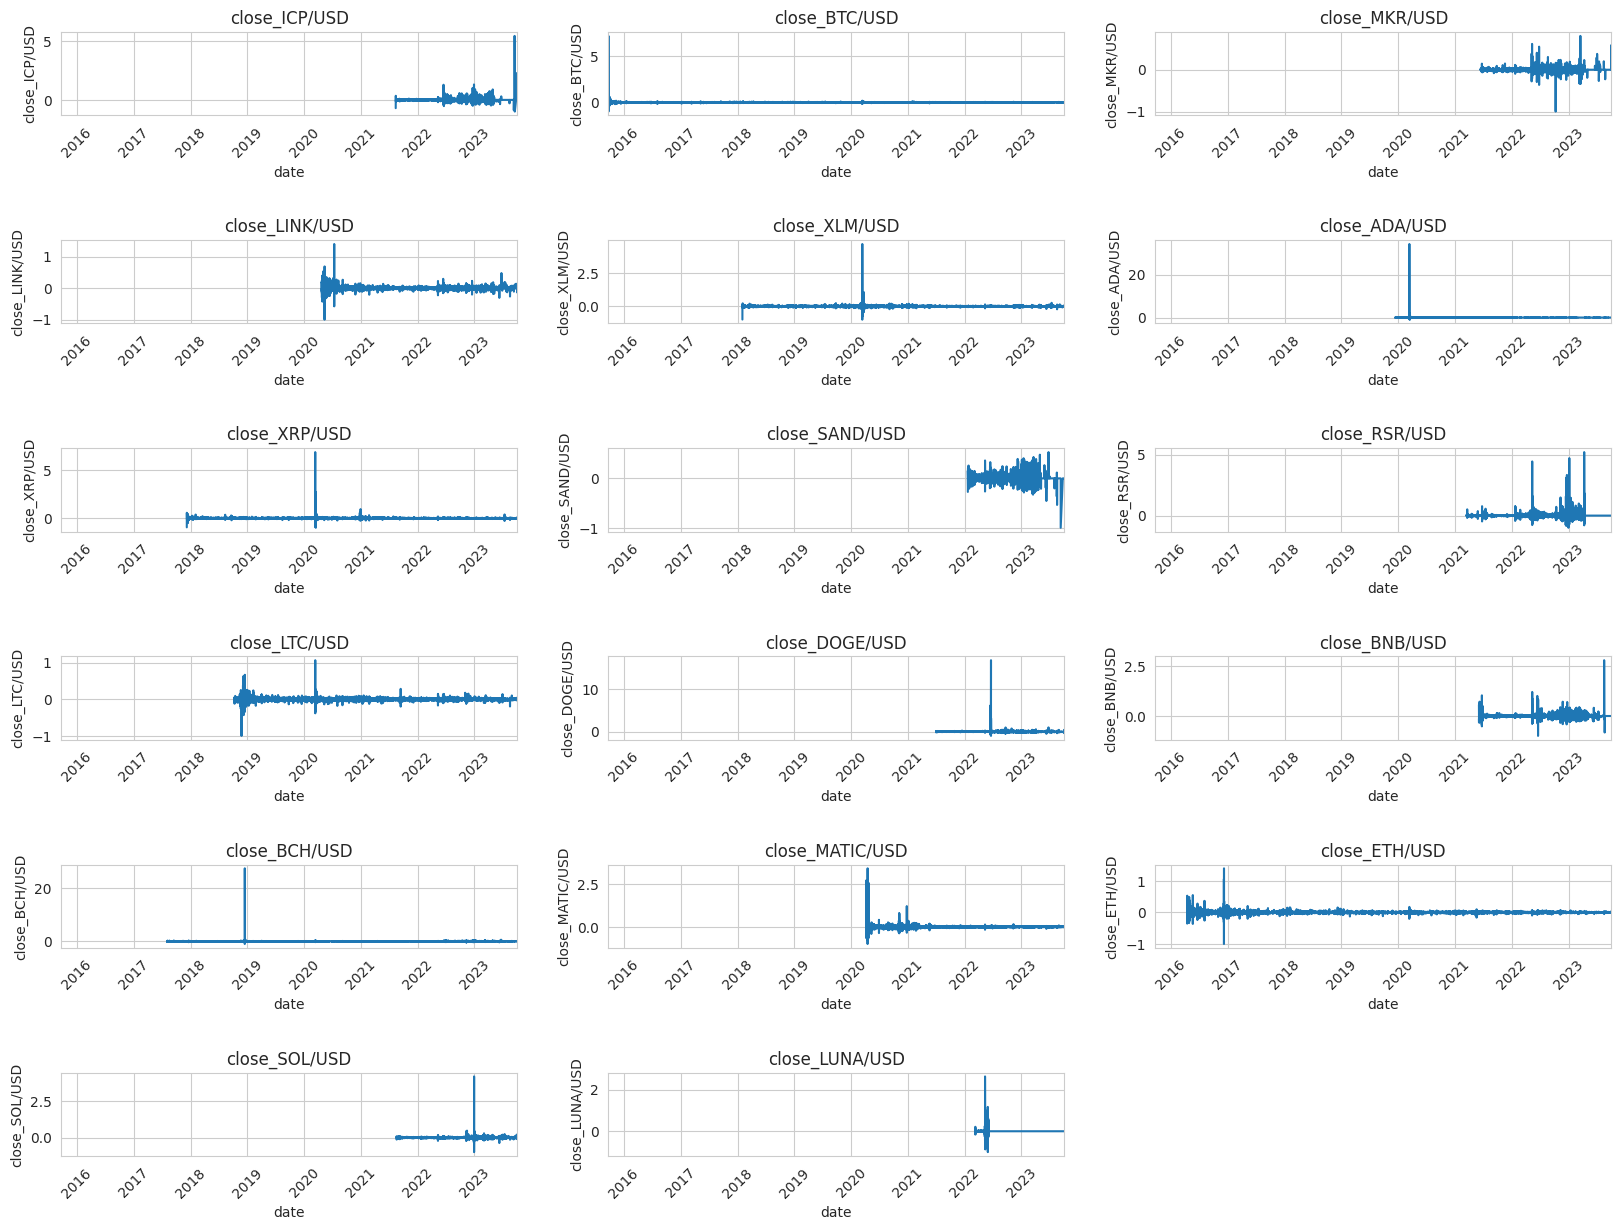

In [105]:
# Get and plot percentage change
returns_df = scaled_df.copy()
returns_df[numeric_cols] = returns_df[numeric_cols].pct_change()

# Create subplots with vertical space using Seaborn
plt.figure(figsize=(20, 20))
grid = plt.GridSpec(8, 3, hspace=1.5)  # Adjust the value of hspace as needed

for i, col in enumerate(returns_df.columns[1:]):
    ax = plt.subplot(grid[i // 3, i % 3])
    sns.lineplot(data=returns_df, x="date", y=col, ax=ax)
    ax.set_title(col)
    
    # Rotate x-axis labels to an oblique angle
    plt.xticks(rotation=45)  # You can adjust the angle as needed

    # Set x-axis limits to display the full date range
    ax.set_xlim(merged_df['date'].min(), merged_df['date'].max())